# 📦 Adaptive Market Planning

This notebook implements the **Bayesian Newsvendor Problem** as a **sequential decision process**. It adaptively learns an optimal order quantity using **stochastic gradient ascent** and **Bayesian belief updates**.

It is adapted from Chapter 3 of Warren B. Powell’s *Sequential Decision Analytics and Modeling: Modeling with Python*.

---

## 🔧 Code Logic Overview

Each simulation follows this loop for $T$ time steps and evaluates policies using Monte Carlo Simulation.

---

## 🔣 Symbol Glossary

| Symbol | Meaning |
|--------|---------|
| $x_n$ | Order quantity at time step $n$ |
| $W_{n+1}$ | Observed demand at time $n+1$ |
| $p$ | Unit selling price |
| $c$ | Unit procurement cost |
| $\alpha_n$ | Stepsize (learning rate) at time $n$ |
| $\mu_k$ | Candidate Poisson demand rate |
| $p^\mu_n$ | Belief vector over $\mu_k$ at time $n$ |
| $F(x, W)$ | One-step profit function |
| $\nabla_x F(x, W)$ | Gradient of the profit w.r.t. $x$ |
| $\Pi_X$ | Projection operator to enforce constraints |
| $g_n$ | Observed gradient at time $n$ |
| $K_n$ | Internal counter in Kesten's rule |
| $\theta$ | Stepsize or policy-specific parameters |

---

## 1️⃣ Inventory Update via Gradient Ascent

The **inventory decision variable** is updated using the following rule:

$$
x_{n+1} = \Pi_X\left[x_n + \alpha_n \cdot \nabla_x F(x_n, W_{n+1})\right]
$$

Where:

- The **gradient** of the profit function is:

$$
\nabla_x F(x, W) =
\begin{cases}
p - c & \text{if } x \leq W \\
-c & \text{if } x > W
\end{cases}
$$

- The **projection** operator $\Pi_X$ enforces constraints (e.g., $x_n \geq 0$):

$$
\Pi_X(z) = \min(\max(z, x_{\min}), x_{\max})
$$

Default bounds are: $x_{\min} = 0$, $x_{\max} = 50$

---

## 2️⃣ Bayesian Belief Update Over $\mu$

Demand follows:

$$
W_{n+1} \sim \text{Poisson}(\mu), \quad \mu \in \{\mu_1, \dots, \mu_K\}
$$

Our belief $p^\mu_n$ over the $K$ candidate means is updated via **Bayes’ Rule**:

$$
p^\mu_{n+1,k} = \frac{\mathbb{P}(W_{n+1} \mid \mu_k) \cdot p^\mu_{n,k}}{\sum_{j=1}^K \mathbb{P}(W_{n+1} \mid \mu_j) \cdot p^\mu_{n,j}}
$$

Where the **Poisson likelihood** is:

$$
\mathbb{P}(W = w \mid \mu_k) = \frac{\mu_k^w e^{-\mu_k}}{w!}
$$

This lets the agent **learn the most likely $\mu$** over time.

---

## 3️⃣ Stepsize Policies (PFAs)

We test three policy function approximators (PFAs) for computing $\alpha_n$:

### ▶️ Harmonic Rule

$$
\alpha_n = \frac{\theta_{\text{step}}}{\theta_{\text{step}} + n - 1}
$$

- Decays over time
- Stable convergence
- Parameter: $\theta_{\text{step}} > 0$

---

### ▶️ Kesten’s Rule

Tracks gradient **sign changes** via $K_n$:

$$
K_n =
\begin{cases}
K_{n-1} + 1 & \text{if } \text{sign}(g_n) \neq \text{sign}(g_{n-1}) \\
K_{n-1} & \text{otherwise}
\end{cases}
$$

Then:

$$
\alpha_n = \frac{\theta_{\text{step}}}{\theta_{\text{step}} + K_n - 1}
$$

- Reduces stepsize on unstable gradients  
- Encourages exploration when learning is smooth

---

### ▶️ AdaGrad Rule

Adaptively scales the stepsize based on gradient history:

$$
\alpha_n = \frac{\eta}{\sqrt{\sum_{i=1}^n g_i^2} + \epsilon}
$$

- $\eta$: Learning rate  
- $\epsilon$: Small constant for numerical stability  
- Tracks **magnitude** of gradient norms

---

## 4️⃣ Simulation Flow

For each time step $n = 0, 1, \dots, T-1$:

1. **Sample demand**: $W_{n+1} \sim \text{Poisson}(\mu^\ast)$  
2. **Compute stepsize** $\alpha_n$ from chosen policy  
3. **Update inventory decision** $x_n \to x_{n+1}$ using $\nabla_x F$  
4. **Update belief** $p^\mu_n \to p^\mu_{n+1}$ via Bayes’ rule  
5. **Compute reward** $r_n = F(x_n, W_{n+1})$

The **total reward** is:

$$
\sum_{n=0}^{T-1} F(x_n, W_{n+1})
$$

---

## 5️⃣ Monte Carlo Evaluation

To assess each strategy:

- Repeat simulation for $N_{\text{sim}}$ runs with different random seeds
- Compute **average total reward**:

$$
\text{AvgReward} = \frac{1}{N_{\text{sim}}} \sum_{i=1}^{N_{\text{sim}}} \sum_{n=1}^{T} F(x_n^{(i)}, W_{n+1}^{(i)})
$$

- Also report **per-step reward**:

$$
\text{AvgStepReward} = \frac{\text{AvgReward}}{T}
$$

---



---

### 🔹 1. **State Variable**

The state captures all relevant information available at time $n$.

$$
S_n = (x_n, p^\mu_n)
$$

Where:
- $x_n$: Current inventory or decision parameter  
- $p^\mu_n$: Current belief (posterior) over candidate demand means $\mu \in \{\mu_1, \dots, \mu_K\}$

#### 🔍 What is $p^\mu_n$?

The vector $p^\mu_n = (p_{n,1}, \dots, p_{n,K})$ represents the agent’s subjective probability over which $\mu_k$ is the true mean of the Poisson demand distribution at time $n$.

- $p_{n,k} = \mathbb{P}(\mu = \mu_k \mid W_1, \dots, W_n)$  
- It summarizes all past demand observations up to time $n$
- Initialized with a prior $p^\mu_0$, and updated using Bayes’ rule after each new demand realization $W_{n+1}$

This evolving belief is what gives the model its **Bayesian adaptivity** — the agent learns which demand model is most plausible as data accumulates.


### 🔹 2. **Decision Variable**

The decision at each step is how to adjust $x_n$ using a learning rule:

$$
\alpha_n: \text{Stepsize — how much to update } x_n
$$

Thus, the next action is:

$$
x_{n+1} = x_n + \alpha_n \cdot \nabla_x F(x_n, W_{n+1})
$$

---

### 🔹 3. **Exogenous Information**

The random demand arriving from the environment:

$$
W_{n+1} \sim \text{Poisson}(\mu), \quad \mu \sim p^\mu_n
$$

Since $\mu$ is unknown, we use our current belief $p^\mu_n$ to model $W_{n+1}$ as a **mixture of Poisson distributions**.

---

### 🔹 4. **Transition Function**

There are two coupled updates:

1. **Inventory update (stochastic gradient ascent):**

$$
x_{n+1} = \Pi_X\left[x_n + \alpha_n \cdot \nabla_x F(x_n, W_{n+1})\right]
$$

2. **Belief update (Bayes rule):**

$$
p^\mu_{n+1,k} = \frac{\mathbb{P}(W_{n+1} \mid \mu_k) \cdot p^\mu_{n,k}}{\sum_j \mathbb{P}(W_{n+1} \mid \mu_j) \cdot p^\mu_{n,j}}
$$

This gives us the next state:

$$
S_{n+1} = (x_{n+1}, p^\mu_{n+1})
$$

---

### 🔹 5. **Objective Function**

Our goal is to maximize expected cumulative profit:

$$
F(x_n, W_{n+1}) = p \cdot \min(x_n, W_{n+1}) - c \cdot x_n
$$

Total objective over horizon $T$:

$$
\max_\pi \ \mathbb{E} \left[ \sum_{n=0}^{T-1} F(x_n, W_{n+1}) \right]
$$

Expectation is taken over:
- Future demand realizations $W_{n+1}$
- Evolving beliefs $p^\mu_n$ over the latent demand mean $\mu$


In [1]:
import numpy as np
from scipy.stats import poisson
import math
import pandas as pd
import matplotlib.pyplot as plt
from typing import Callable, List, Dict, Tuple, Union
from joblib import Parallel, delayed
import seaborn as sns

In [2]:
def transition_x(
    x_n: float,
    W_n1: float,
    alpha_n: float,
    p: float,
    c: float,
    projection: Callable[[float], float] = lambda x: max(0, x)
) -> Tuple[float, float]:
    """
    Computes the next inventory level x_{n+1} using stochastic gradient ascent.

    Args:
        x_n (float): Current inventory level.
        W_n1 (float): Observed demand at time n+1.
        alpha_n (float): Step size for the gradient update.
        p (float): Selling price.
        c (float): Unit cost.
        projection (Callable): Projection function to enforce constraints.

    Returns:
        Tuple[float, float]: (x_{n+1}, gradient used)
    """
    gradient = (p - c) if x_n <= W_n1 else -c
    x_next = x_n + alpha_n * gradient
    return projection(x_next), gradient

In [3]:
def project_to_box_constraint(z: float, lower: float = 0.0, upper: float = 50.0) -> float:
    """
    Projects a scalar value onto a closed interval using Euclidean (L2) projection.

    This solves the 1D constrained optimization:
        Π_X[z] = argmin_{x ∈ X} ||x - z||_2
    where X = [lower, upper].

    Example use case: ensuring inventory or resource decisions remain within min/max bounds.

    Args:
        z (float): Value to project.
        lower (float): Lower bound of the constraint interval.
        upper (float): Upper bound of the constraint interval.

    Returns:
        float: The projected value, clipped to the interval [lower, upper].
    """
    return min(max(z, lower), upper)

In [4]:
def transition_p(
    p_mu_n: np.ndarray,
    W_n1: int,
    mu_values: np.ndarray
) -> np.ndarray:
    """
    Performs Bayesian update of the belief vector over discrete Poisson mean values.

    Args:
        p_mu_n (np.ndarray): Current belief vector over Poisson means.
        W_n1 (int): Observed demand at time n+1.
        mu_values (np.ndarray): Discrete set of candidate Poisson means.

    Returns:
        np.ndarray: Updated belief vector p_mu_{n+1}
    """
    # Compute Poisson likelihoods using scipy
    likelihoods = poisson.pmf(W_n1, mu_values)

    # Bayesian update: unnormalized posterior
    unnormalized = likelihoods * p_mu_n

    # Normalize to get valid probability vector
    return unnormalized / np.sum(unnormalized)

## 🔹 Expected Profit Function

The firm's expected profit is:
$$
\mathbb{E}_W \left[ p \min(x, W) - c x \right]
$$

Here’s what each term means:
- $W$: Random demand with known distribution
- $F(x, W) = p \min(x, W) - c x$: The **profit function**

In [5]:
def profit_function(x: float, W: float, p: float = 10.0, c: float = 4.0) -> float:
    """
    Profit function defined as:

        F(x, W) = p * min(x, W) - c * x

    This represents the reward received when fulfilling demand W with inventory x,
    earning price p per unit sold and incurring cost c per unit ordered.

    Args:
        x (float): Inventory level / decision variable.
        W (float): Realized demand.
        p (float, optional): Unit selling price. Defaults to 10.0.
        c (float, optional): Unit cost. Defaults to 4.0.

    Returns:
        float: The profit (reward) for this period.
    """
    return p * min(x, W) - c * x

## ⚙️ Stepsize Policies (PFAs)

### 1. **Harmonic Rule**
$$
\alpha_n = \frac{\theta_{\text{step}}}{\theta_{\text{step}} + n - 1}
$$

### 2. **Kesten's Rule**
$$
K_n = \begin{cases}
K_{n-1} + 1 & \text{if gradient switches sign} \\
K_{n-1} & \text{otherwise}
\end{cases}
$$
$$
\alpha_n = \frac{\theta_{\text{step}}}{\theta_{\text{step}} + K_n - 1}
$$

### 3. **AdaGrad Rule**
$$
\alpha_{n,i} = \frac{\eta}{\sqrt{\sum_{m=1}^n (g_{m,i})^2} + \epsilon}
$$

---

In [6]:
def harmonic_stepsize(n: int, theta_step: float) -> float:
    """
    Computes the stepsize using the Harmonic Rule.

    Harmonic Rule:
        α_n = θ_step / (θ_step + n - 1)

    Args:
        n (int): Current time step (1-based index: n = 1, 2, ...).
        theta_step (float): Positive scaling parameter controlling decay rate.

    Returns:
        float: Stepsize α_n
    """
    return theta_step / (theta_step + n - 1)

In [7]:
def kesten_stepsize(
    grad_prev: np.ndarray,
    grad_curr: np.ndarray,
    K_n_prev: int,
    theta_step: float
) -> Tuple[float, int]:
    """
    Computes the Kesten stepsize and updates K_n based on gradient sign changes.

    Args:
        grad_prev (np.ndarray): Previous gradient vector (∇F_{n-1}).
        grad_curr (np.ndarray): Current gradient vector (∇F_n).
        K_n_prev (int): Previous K_n value.
        theta_step (float): Scaling parameter for initial stepsize.

    Returns:
        Tuple[float, int]: (stepsize α_n, updated K_n)
    """
    # Determine if any component of gradient switches sign
    sign_switch = np.any(grad_prev * grad_curr < 0)

    # Update K_n accordingly
    K_n = K_n_prev + 1 if sign_switch else K_n_prev

    # Compute stepsize based on updated K_n
    alpha_n = theta_step / (theta_step + K_n - 1)

    return alpha_n, K_n

In [8]:
def adagrad_stepsize(
    gradient_history: List[float],
    eta: float = 1.0,
    epsilon: float = 1e-8
) -> float:
    """
    Computes AdaGrad stepsize in 1D.

    Formula:
        α_n = η / (sqrt(Σ g_i^2) + ε)

    Args:
        gradient_history (List[float]): List of past gradients.
        eta (float): Learning rate scale.
        epsilon (float): Smoothing term to avoid division by zero.

    Returns:
        float: Stepsize α_n
    """
    
    squared_sum = sum(g**2 for g in gradient_history)
    return eta / (math.sqrt(squared_sum) + epsilon)

In [9]:
policy_configs = [
    # Harmonic Rule Variants
    {
        "policy": harmonic_stepsize,
        "name": "harmonic_theta_1.0",
        "params": {"theta_step": 1.0}
    },
    {
        "policy": harmonic_stepsize,
        "name": "harmonic_theta_5.0",
        "params": {"theta_step": 5.0}
    },
    {
        "policy": harmonic_stepsize,
        "name": "harmonic_theta_10.0",
        "params": {"theta_step": 10.0}
    },
    {
        "policy": harmonic_stepsize,
        "name": "harmonic_theta_50.0",
        "params": {"theta_step": 50.0}
    },

    # Kesten Rule Variants
    {
        "policy": kesten_stepsize,
        "name": "kesten_theta_1.0",
        "params": {"theta_step": 1.0},
        "initial_state": {"K_n": 1}
    },
    {
        "policy": kesten_stepsize,
        "name": "kesten_theta_5.0",
        "params": {"theta_step": 5.0},
        "initial_state": {"K_n": 1}
    },
    {
        "policy": kesten_stepsize,
        "name": "kesten_theta_10.0",
        "params": {"theta_step": 10.0},
        "initial_state": {"K_n": 1}
    },
    {
        "policy": kesten_stepsize,
        "name": "kesten_theta_50.0",
        "params": {"theta_step": 50.0},
        "initial_state": {"K_n": 1}
    },

    # AdaGrad Rule Variants
    {
        "policy": adagrad_stepsize,
        "name": "adagrad_eta_1.0",
        "params": {"eta": 1.0, "epsilon": 1e-1},
        "initial_state": {"gradients": [10.0]}
    },
    {
        "policy": adagrad_stepsize,
        "name": "adagrad_eta_2.0",
        "params": {"eta": 2.0, "epsilon": 1e-1},
        "initial_state": {"gradients": [10.0]}
    },
    {
        "policy": adagrad_stepsize,
        "name": "adagrad_eta_5.0",
        "params": {"eta": 5.0, "epsilon": 1e-1},
        "initial_state": {"gradients": [10.0]}
    }
]

In [10]:
def simulate_bayesian_inventory_policy(
    T: int,
    x_0: float,
    policy_config: dict,
    reward_fn: Callable[[float, float], float],
    projection_fn: Callable[[float], float],
    mu_choices: List[float],
    p_mu_0: np.ndarray,
    true_mu: float,
    p: float,
    c: float,
    seed: int = 42,
    return_trajectories: bool = False
) -> Union[float, Tuple[List[float], List[np.ndarray]]]:
    """
    Simulate Bayesian adaptive inventory decisions using stochastic gradient ascent and belief updates.

    Args:
        T (int): Number of time steps.
        x_0 (float): Initial inventory level.
        policy_config (dict): Stepsize policy configuration.
        reward_fn (Callable): Profit function F(x, W).
        projection_fn (Callable): Projection operator Π_X.
        mu_choices (List[float]): Candidate Poisson means (μ_k).
        p_mu_0 (np.ndarray): Initial prior belief vector over μ.
        true_mu (float): True Poisson demand mean used in simulation.
        p (float): Selling price.
        c (float): Procurement cost.
        seed (int): Random seed for reproducibility.
        return_trajectories (bool): If True, returns full reward and belief traces.

    Returns:
        Union[float, Tuple[List[float], List[np.ndarray]]]: Total reward over T time steps
        OR (reward trace, belief trace) if return_trajectories is True.
    """
    
    # Input validation
    if T <= 0:
        raise ValueError("T must be positive")
    if len(mu_choices) != len(p_mu_0):
        raise ValueError("Length of mu_choices must match length of p_mu_0")
    if not np.allclose(np.sum(p_mu_0), 1.0):
        raise ValueError("p_mu_0 must sum to 1.0")
    
    np.random.seed(seed)
    x_n = x_0
    p_mu_n = p_mu_0.copy()
    mu_choices = np.array(mu_choices)

    rewards = []
    beliefs = []

    policy_fn = policy_config['policy']
    policy_params = policy_config['params'].copy()  # Avoid mutation side effects

    # Initialize internal state based on policy type
    if policy_fn.__name__ == "kesten_stepsize":
        K_n = policy_config.get('initial_state', {}).get('K_n', 1)
        grad_prev = 0.0
    elif policy_fn.__name__ == "adagrad_stepsize":
        # Create a fresh copy of gradient history to avoid mutation
        gradient_history = policy_config.get('initial_state', {}).get('gradients', []).copy()

    for n in range(T):
        # Step 1: Sample demand from Poisson(true_mu)
        W_n1 = np.random.poisson(true_mu)

        # Step 2: Compute stepsize α_n using selected policy
        if policy_fn.__name__ == "kesten_stepsize":
            grad_curr = (p - c) if x_n <= W_n1 else -c
            # Handle first iteration when grad_prev is 0
            if n == 0:
                alpha_n = policy_params['theta_step'] / (policy_params['theta_step'] + K_n - 1)
                K_n = K_n  # Keep K_n unchanged for first iteration
            else:
                alpha_n, K_n = policy_fn(
                    grad_prev=np.array([grad_prev]),
                    grad_curr=np.array([grad_curr]),
                    K_n_prev=K_n,
                    **policy_params
                )
            grad_prev = grad_curr

        elif policy_fn.__name__ == "adagrad_stepsize":
            alpha_n = policy_fn(
                gradient_history=gradient_history,
                **policy_params
            )

        else:  # Harmonic rule (stateless)
            alpha_n = policy_fn(n=n + 1, **policy_params)

        # Step 3: Update inventory x_n → x_{n+1} using gradient ascent
        x_n, gradient = transition_x(
            x_n=x_n,
            W_n1=W_n1,
            alpha_n=alpha_n,
            p=p,
            c=c,
            projection=projection_fn
        )

        # Step 4: Update AdaGrad's gradient history
        if policy_fn.__name__ == "adagrad_stepsize":
            gradient_history.append(gradient)

        # Step 5: Update Bayesian belief vector p^μ_n → p^μ_{n+1}
        p_mu_n = transition_p(
            p_mu_n=p_mu_n,
            W_n1=W_n1,
            mu_values=mu_choices
        )

        # Step 6: Compute and store reward
        reward = reward_fn(x_n, W_n1)
        rewards.append(reward)

        # Optional: track belief trajectory
        if return_trajectories:
            beliefs.append(p_mu_n.copy())

    if return_trajectories:
        return rewards, beliefs

    return sum(rewards)

In [11]:
def parallel_evaluate_policy_monte_carlo(
    N_sim: int,
    T: int,
    x_0: float,
    policy_config: Dict,
    reward_fn: Callable,
    projection_fn: Callable,
    mu_choices: List[float],
    p_mu_0: np.ndarray,
    true_mu: float,
    p: float,
    c: float,
    n_jobs: int = -1  # Use all available CPU cores
) -> float:
    """
    Runs multiple Monte Carlo simulations in parallel to evaluate the average total reward 
    of a Bayesian inventory policy under a specific stepsize configuration.

    Args:
        N_sim (int): Number of Monte Carlo simulations to run.
        T (int): Number of time steps in each simulation.
        x_0 (float): Initial inventory level.
        policy_config (Dict): Dictionary defining the stepsize policy and its parameters.
        reward_fn (Callable): Profit function F(x, W).
        projection_fn (Callable): Projection function Π_X to enforce inventory constraints.
        mu_choices (List[float]): Discrete candidate values for the Poisson demand mean μ.
        p_mu_0 (np.ndarray): Initial belief vector over μ_choices.
        true_mu (float): True Poisson mean used to generate demand in the simulation.
        p (float): Selling price per unit.
        c (float): Procurement cost per unit.
        n_jobs (int): Number of parallel workers to use (default: -1 = use all available cores).

    Returns:
        float: The average total reward across all N_sim simulations.
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(simulate_bayesian_inventory_policy)(
            T=T,
            x_0=x_0,
            policy_config=policy_config,
            reward_fn=reward_fn,
            projection_fn=projection_fn,
            mu_choices=mu_choices,
            p_mu_0=p_mu_0,
            true_mu=true_mu,
            p=p,
            c=c,
            seed=42 + i
        ) for i in range(N_sim)
    )
    return np.mean(results)

In [12]:
def parallel_evaluate_all_strategies(
    policy_configs: List[Dict],
    N_sim: int,
    T: int,
    x_0: float,
    reward_fn: Callable,
    projection_fn: Callable,
    mu_choices: List[float],
    p_mu_0: np.ndarray,
    true_mu: float,
    p: float,
    c: float,
    n_jobs: int = -1
) -> List[Dict]:
    """
    Evaluates multiple adaptive inventory control strategies (stepsize policies)
    using Monte Carlo simulation in parallel.

    For each policy configuration provided, the function runs N_sim simulations 
    and computes the average total reward over T time steps.

    Args:
        policy_configs (List[Dict]): List of policy configurations, each specifying 
                                     a stepsize function, parameters, and name.
        N_sim (int): Number of Monte Carlo replications per policy.
        T (int): Horizon length (number of decision periods).
        x_0 (float): Initial inventory level.
        reward_fn (Callable): Profit function F(x, W).
        projection_fn (Callable): Projection operator Π_X to constrain decisions.
        mu_choices (List[float]): Candidate Poisson means for demand modeling.
        p_mu_0 (np.ndarray): Initial prior belief vector over μ_choices.
        true_mu (float): True Poisson mean used to generate demand in simulations.
        p (float, optional): Unit selling price. Defaults to 10.0.
        c (float, optional): Unit procurement cost. Defaults to 4.0.
        n_jobs (int, optional): Number of parallel jobs to use. Defaults to -1 (all CPUs).

    Returns:
        List[Dict]: A list of dictionaries, one per policy, each containing:
            - "policy": Name of the policy
            - "avg_reward": Average total reward over N_sim simulations
    """
    results = []
    for config in policy_configs:
        avg_reward = parallel_evaluate_policy_monte_carlo(
            N_sim=N_sim,
            T=T,
            x_0=x_0,
            policy_config=config,
            reward_fn=reward_fn,
            projection_fn=projection_fn,
            mu_choices=mu_choices,
            p_mu_0=p_mu_0,
            true_mu=true_mu,
            p=p,
            c=c,
            n_jobs=n_jobs
        )
        results.append({
            "policy": config["name"],
            "avg_reward": avg_reward
        })
    return results


In [13]:
def evaluate_policy_with_trajectories(
    N_sim: int,
    T: int,
    x_0: float,
    policy_config: Dict,
    reward_fn: Callable,
    projection_fn: Callable,
    mu_choices: List[float],
    p_mu_0: np.ndarray,
    true_mu: float,
    p: float,
    c: float,
    n_jobs: int = -1
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Parallel evaluation with reward and belief trajectory capture.
    Returns:
        - mean_reward: float
        - all_rewards: (N_sim, T)
        - all_beliefs: (N_sim, T, K)
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(simulate_bayesian_inventory_policy)(
            T=T,
            x_0=x_0,
            policy_config=policy_config,
            reward_fn=reward_fn,
            projection_fn=projection_fn,
            mu_choices=mu_choices,
            p_mu_0=p_mu_0,
            true_mu=true_mu,
            p=p,
            c=c,
            seed=42 + i,
            return_trajectories=True
        ) for i in range(N_sim)
    )
    
    all_rewards, all_beliefs = zip(*results)  # unzip into tuples
    rewards_array = np.array(all_rewards)
    beliefs_array = np.array(all_beliefs)
    mean_reward = np.sum(rewards_array, axis=1).mean()
    
    return mean_reward, rewards_array, beliefs_array

In [14]:
# --- Parameters ---
N_sim = 100 # Number of Monte Carlo simulations
T = 365 # Time horizon (number of decision periods)
x_0 = 1 # Initial inventory level
true_mu = 4.0 # True Poisson mean for demand
p = 26.0 # Selling price per unit
c = 20.0 # Procurement cost per unit
mu_choices = [2, 4, 6, 8] # Discrete candidate Poisson means
p_mu_0 = np.array([0.3, 0.1, 0.2, 0.4]) # Initial belief vector over mu_choices

# Filter policy configs
policy_configs = [
    *[config for config in policy_configs if config["name"].startswith("harmonic")],
    *[config for config in policy_configs if config["name"].startswith("kesten")],
    *[config for config in policy_configs if config["name"].startswith("adagrad")]
]

# Run all policies
policy_data = []
for config in policy_configs:
    avg_reward, rewards_arr, beliefs_arr = evaluate_policy_with_trajectories(
        N_sim=N_sim,
        T=T,
        x_0=x_0,
        policy_config=config,
        reward_fn=profit_function,
        projection_fn=project_to_box_constraint,
        mu_choices=mu_choices,
        p_mu_0=p_mu_0,
        true_mu=true_mu,
        p=p,
        c=c,
        n_jobs=-1
    )
    policy_data.append({
        "name": config["name"],
        "avg_reward": avg_reward,
        "rewards": rewards_arr,
        "beliefs": beliefs_arr
    })

In [15]:
# Set global style
plt.style.use("default")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("colorblind")

# --- DataFrame ---
df = pd.DataFrame([
    {"policy": d["name"], "avg_reward": d["avg_reward"]}
    for d in policy_data
])
df["avg_per_step"] = df["avg_reward"] / T
df = df.sort_values(by="avg_per_step", ascending=True)

# Round avg_reward and avg_per_step
df["avg_reward"] = df["avg_reward"].round(2)
df["avg_per_step"] = df["avg_per_step"].round(2)

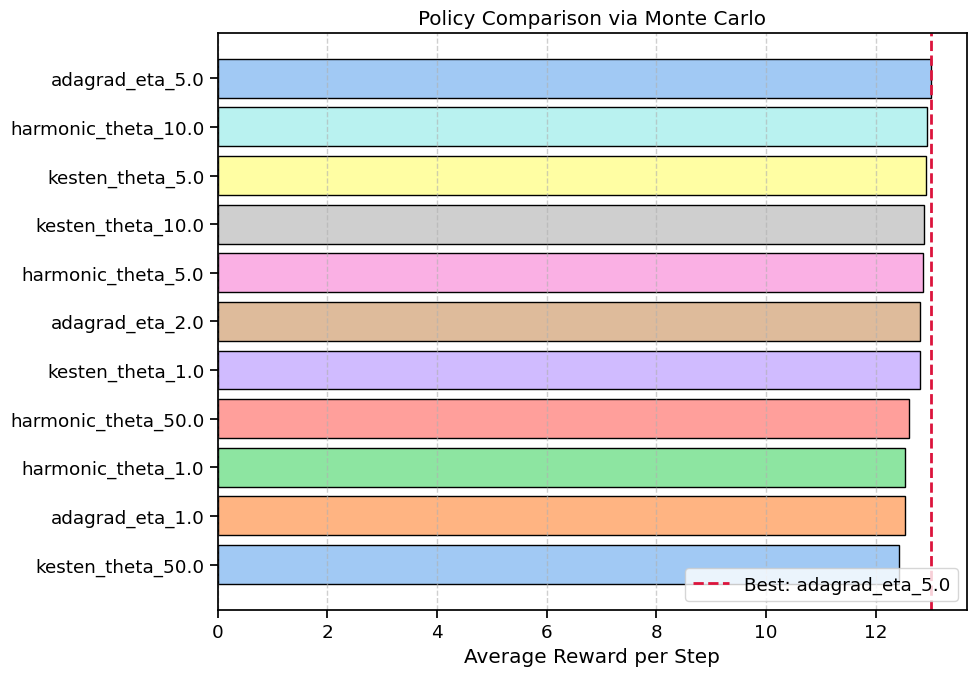

In [16]:
# --- Plot 1: Bar Chart ---
plt.style.use("default")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("colorblind")

plt.figure(figsize=(10, 7))
plt.barh(df["policy"], df["avg_per_step"], color=sns.color_palette("pastel"), edgecolor="black")
best_row = df.iloc[-1]
plt.axvline(best_row["avg_per_step"], color="crimson", linestyle="--", linewidth=2,
            label=f"Best: {best_row['policy']}")
plt.xlabel("Average Reward per Step")
plt.title("Policy Comparison via Monte Carlo")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

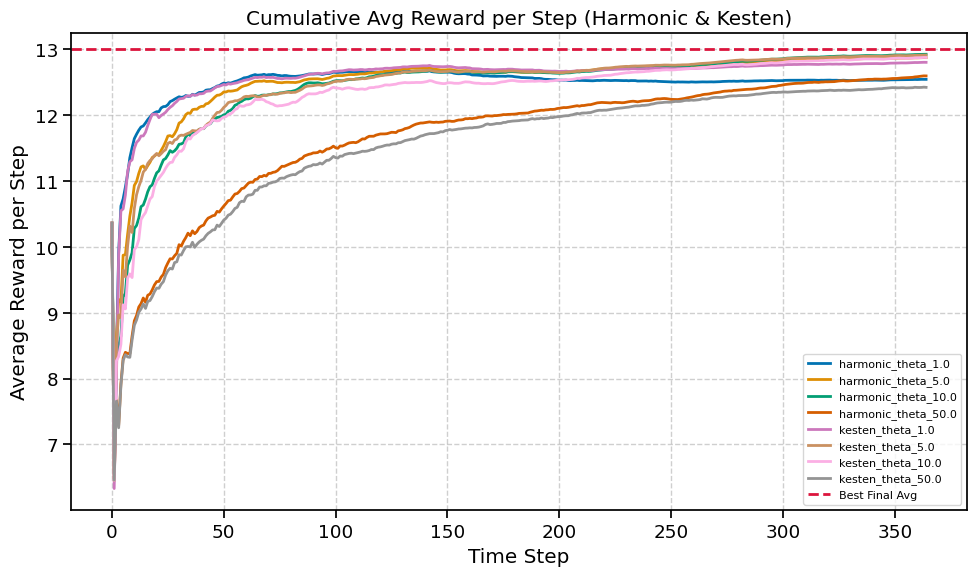

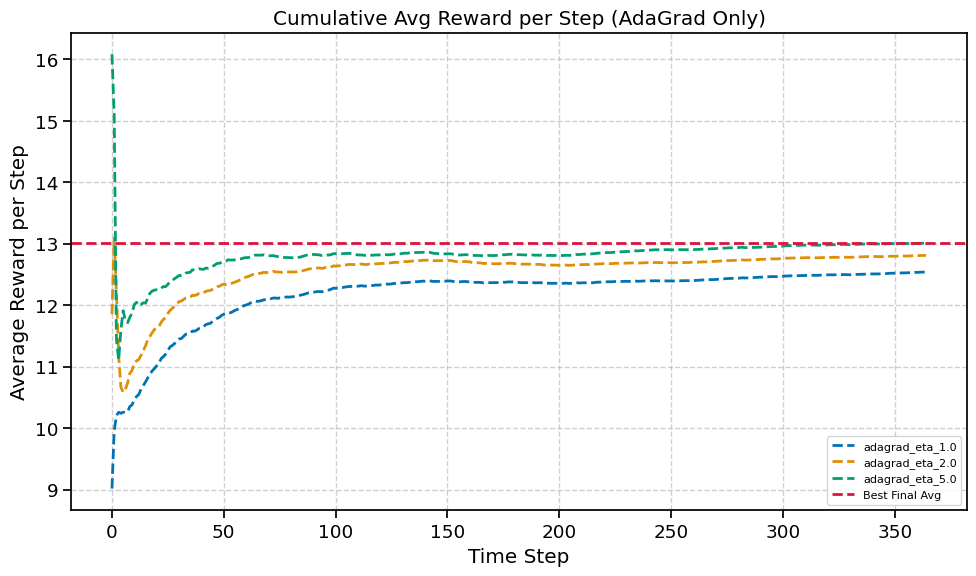

In [17]:
# --- Plot 2A: Non-AdaGrad Policies ---
plt.figure(figsize=(10, 6))
for d in policy_data:
    if "adagrad" not in d["name"].lower():
        mean_rewards = d["rewards"].mean(axis=0)
        cum_avg_reward = np.cumsum(mean_rewards) / (np.arange(1, T + 1))
        plt.plot(cum_avg_reward, label=d["name"], linewidth=2)

plt.axhline(df["avg_per_step"].max(), color="crimson", linestyle="--", linewidth=2, label="Best Final Avg")
plt.title("Cumulative Avg Reward per Step (Harmonic & Kesten)")
plt.xlabel("Time Step")
plt.ylabel("Average Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=8, loc="lower right")
plt.tight_layout()
plt.show()

# --- Plot 2B: AdaGrad Policies Only ---
plt.figure(figsize=(10, 6))
for d in policy_data:
    if "adagrad" in d["name"].lower():
        mean_rewards = d["rewards"].mean(axis=0)
        cum_avg_reward = np.cumsum(mean_rewards) / (np.arange(1, T + 1))
        plt.plot(cum_avg_reward, label=d["name"], linestyle="--", linewidth=2)

plt.axhline(df["avg_per_step"].max(), color="crimson", linestyle="--", linewidth=2, label="Best Final Avg")
plt.title("Cumulative Avg Reward per Step (AdaGrad Only)")
plt.xlabel("Time Step")
plt.ylabel("Average Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=8, loc="lower right")
plt.tight_layout()
plt.show()


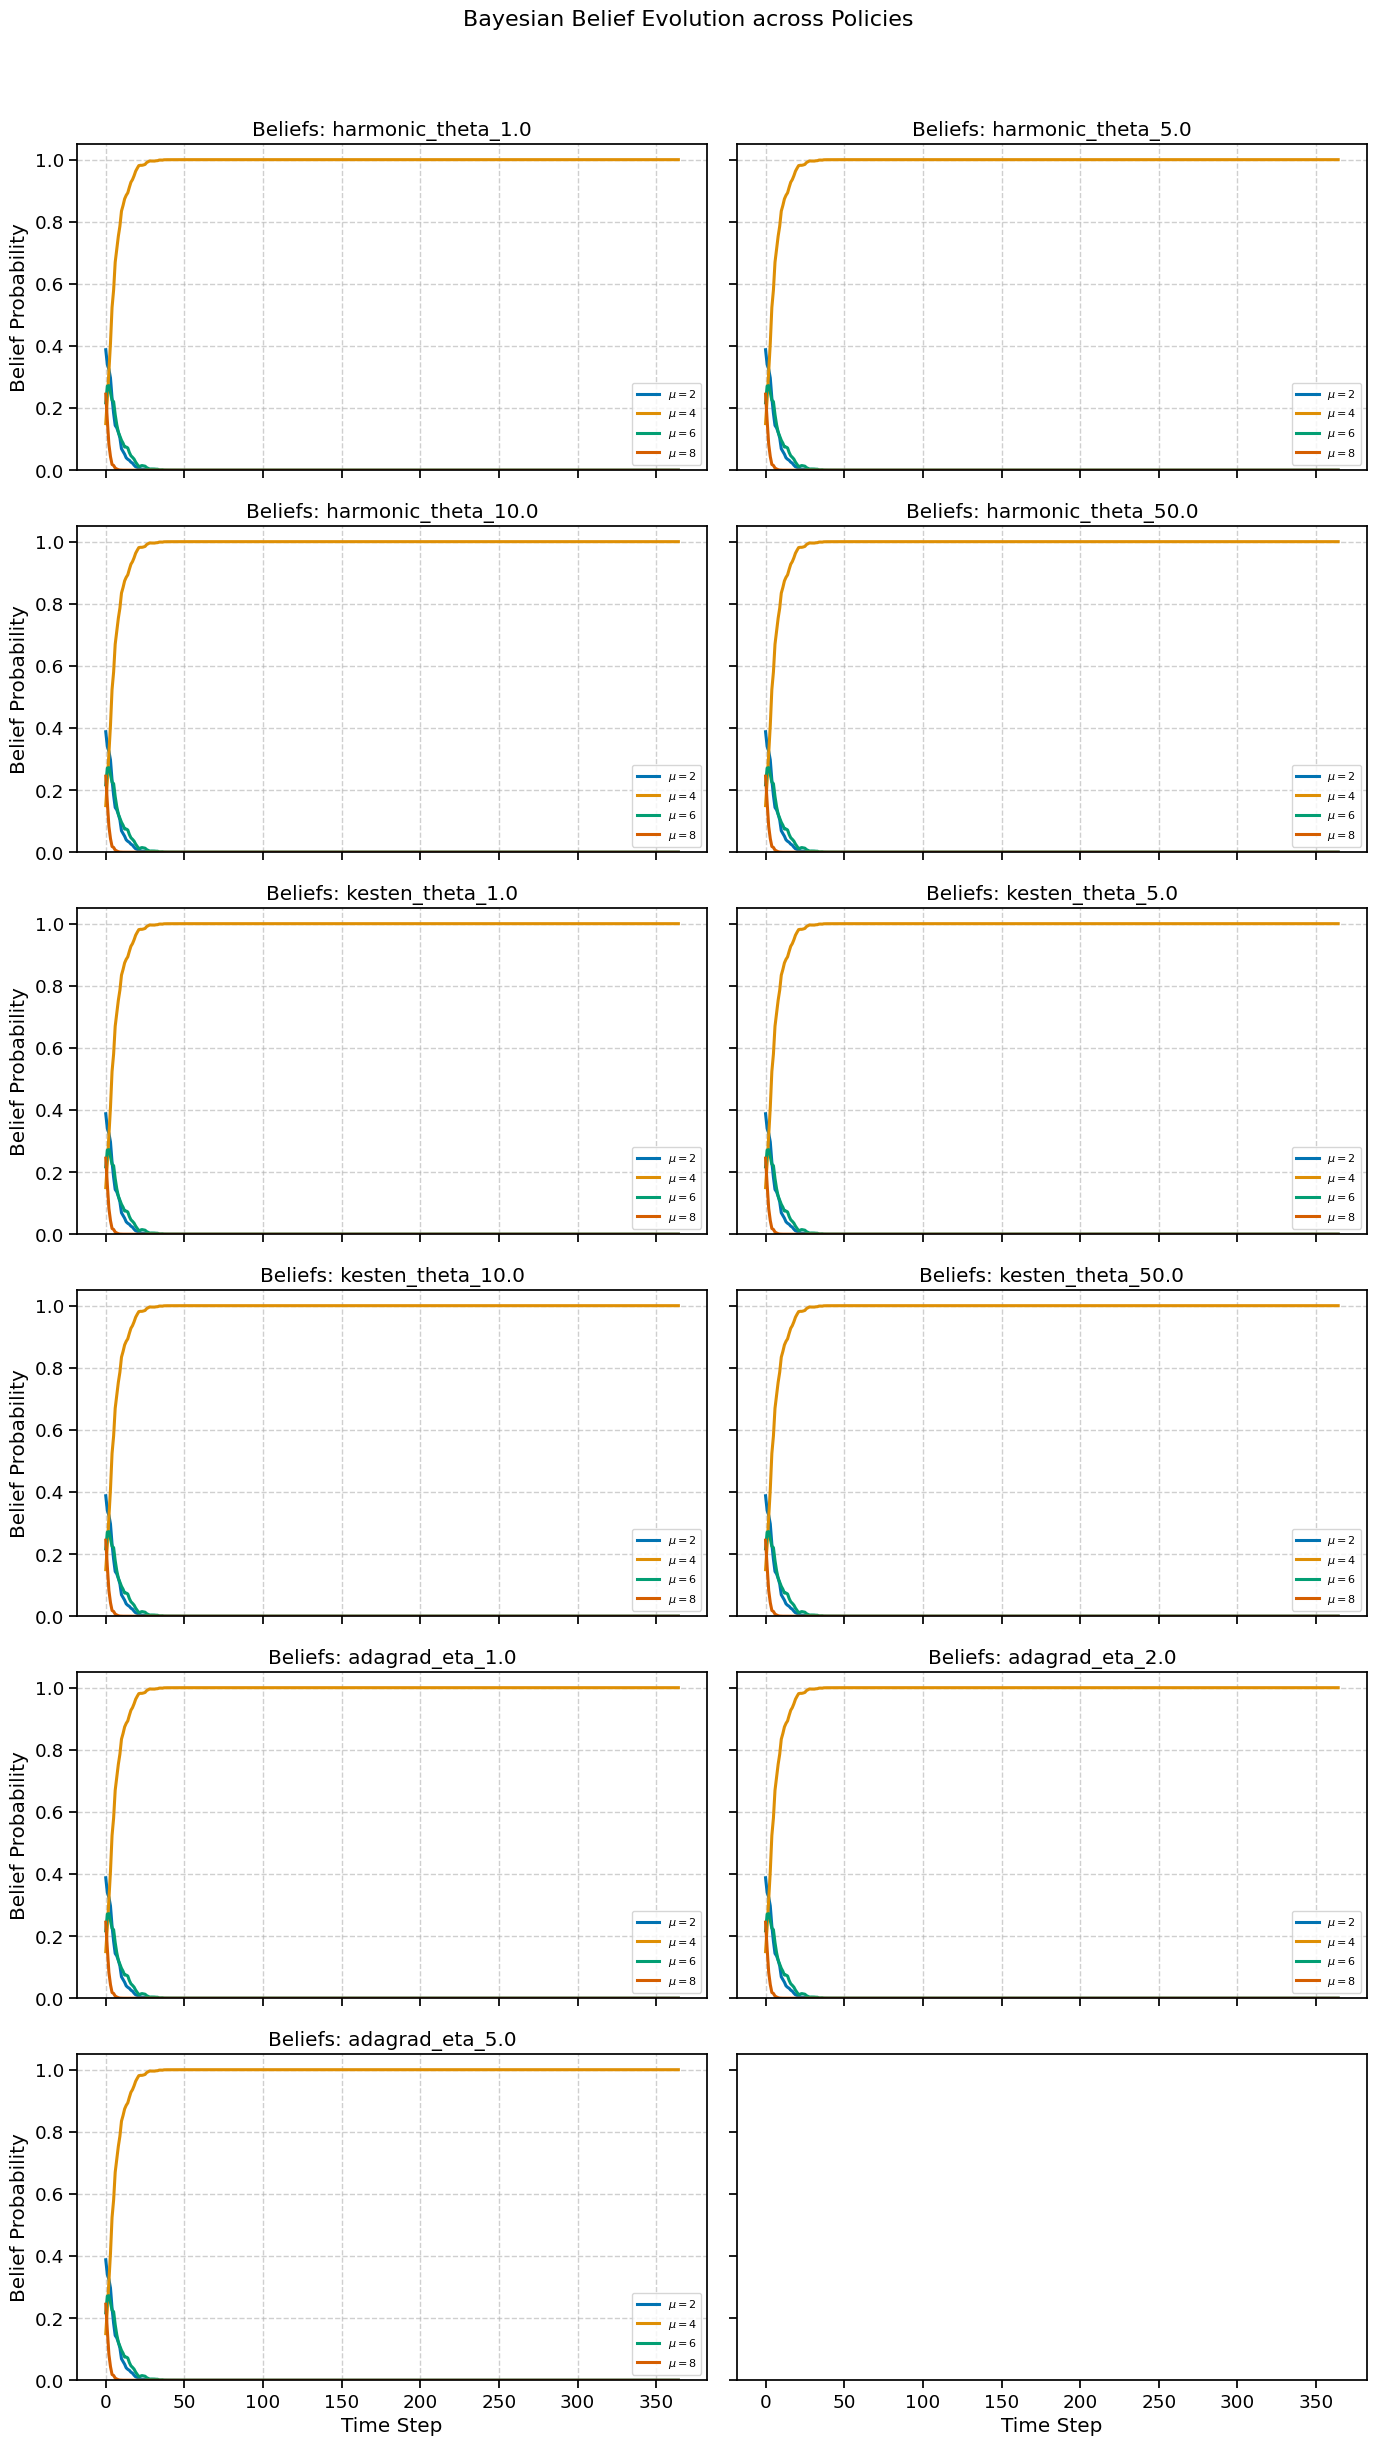

In [18]:
# --- Plot 3: Belief Evolution ---
cols = 2
rows = (len(policy_data) + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True, sharey=True)

for idx, d in enumerate(policy_data):
    ax = axes[idx // cols, idx % cols]
    mean_beliefs = d["beliefs"].mean(axis=0)
    for i, mu in enumerate(mu_choices):
        ax.plot(mean_beliefs[:, i], label=fr"$\mu = {mu}$", linewidth=2.2)
    ax.set_title(f"Beliefs: {d['name']}")
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(fontsize=8)

for ax in axes[-1]:
    ax.set_xlabel("Time Step")
for row in axes:
    row[0].set_ylabel("Belief Probability")

plt.suptitle("Bayesian Belief Evolution across Policies", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()